# 0. Configuration and Imports

In [143]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import cv2
import os

VIDEO_FILE = 'Videos/Gum_Vid.mp4'
FRAME_DIR = 'frames'
TARGET_FPS = 3
MAX_IMAGES_PER_SEQUENCE = 200

FEATURE_ALGORITHMS = {
    "ORB": cv2.ORB_create(nfeatures=2000),
    "SIFT": cv2.SIFT_create(),
    "BRISK": cv2.BRISK_create()
}

MATCHING_ALGORITHM = "BRISK"  # Options: "ORB", "SIFT", "BRISK"
LOWES_RATIO = 0.75
MIN_INLIER_COUNT = 15

OUTPUT_KEYPOINTS_DIR = "output_keypoints"
OUTPUT_ANALYSIS_DIR  = "output_analysis"
OUTPUT_MATCHES_DIR   = "output_matches"
OUTPUT_SCENE_DIR     = "output_scene"

# 1. Video Aquisition

**Methodology and Refinements:** The video acquisition process was iterative. Initial attempts yielded unsatisfactory results for the SfM pipeline due to several factors. The primary issues identified were:

- **Insufficient Parallax:** The initial camera movement was too slow, resulting in minimal difference between consecutive frames.
- **Incorrect Panning:** The camera was only rotated around the subject (panning), which does not generate the necessary baseline for effective triangulation.

After further research and analysis, the capture strategy was revised significantly to address these challenges.

- **Panning Technique:** The panning style was changed to a method that introduces greater parallax. The mobile phone was moved not just in a rotational arc but also on a horizontal, lateral axis relative to the subject. [cite_start]This combination of circular and lateral motion is highly effective for SfM.

 - **Background and Scene Setup:** To help distinguish the subject from the background, a simple and controlled environment was created. A mouse pad was used to provide a clean, textured surface for the subject, and the white surface of the desk was used to create a clear distinction from the floor. This minimizes the risk of detecting and matching incorrect features in the background.

- **Lighting Control:** To achieve the "consistent and diffuse lighting" recommended by the project guidelines, filming was conducted indoors. The room's blinds were partially closed to soften any direct sunlight, and all other artificial lights were turned off. This strategy successfully minimized the creation of harsh, moving shadows that can disrupt feature tracking.

- **Subject Selection:** Multiple subjects were tested. [cite_start]Based on SfM principles, subjects were chosen to have desirable characteristics. We specifically avoided objects with reflective or featureless surfaces. Instead, we prioritized subjects with multiple colors and rich textures, as this ensures a higher density of distinct, high-quality features for the algorithms to detect and match.

This revised and documented approach produced a video sequence far more suitable for the subsequent stages of the reconstruction pipeline.

# 2. Frame Extraction

**Methodology:**
A video is essentially a rapid sequence of images. For SfM, using every single frame is computationally expensive and often redundant, as consecutive frames in a standard video can be nearly identical. [cite_start]Therefore, we must select a "feasible interval" to extract frames that provides sufficient visual overlap without overwhelming the system.  [cite_start]The project guidelines suggest an overlap of approximately 70-80% between consecutive frames for good results. 

In our implementation, we achieve this by defining a `TARGET_FPS` (Frames Per Second) of 3. Given a standard video source that runs at 30 FPS, this target effectively means we are sampling approximately every 10th frame. This approach strikes a balance:
* It ensures that there are significant changes between frames, providing a good baseline for triangulation.
* [cite_start]It maintains enough visual overlap for feature matchers to find a robust number of corresponding keypoints between one frame and the next. 

The `extract_frames` function uses OpenCV's `cv2.VideoCapture` to read the video file. It calculates the necessary `frame_interval` based on the video's original FPS and our `TARGET_FPS`. It then iterates through the video, saving a frame to the output directory only when `frame_index % frame_interval == 0`.

***

In [144]:
print("\n STEP 2: FRAME EXTRACTION\n")

def extract_frames(video_path, output_dir, target_fps):
    if not os.path.exists(output_dir): 
        os.makedirs(output_dir)

    video = cv2.VideoCapture(video_path)

    if not video.isOpened(): 
        print(f"Error: Could not open video file {video_path}"); 
        return
    video_fps = video.get(cv2.CAP_PROP_FPS) or 30; frame_interval = int(round(video_fps / target_fps))
    saved_count, frame_index = 0, 0

    while True:
        ret, frame = video.read()
        if not ret: break
        if frame_index % frame_interval == 0: cv2.imwrite(os.path.join(output_dir, f"frame_{saved_count:04d}.jpg"), frame); saved_count += 1
        frame_index += 1

    video.release()
    print(f"Extraction complete. {saved_count} frames saved to '{output_dir}'.\n")

sequence_name = os.path.splitext(os.path.basename(VIDEO_FILE))[0]
output_sequence_dir = os.path.join(FRAME_DIR, sequence_name)

if not os.path.isdir(output_sequence_dir) or not os.listdir(output_sequence_dir): 
    extract_frames(VIDEO_FILE, output_sequence_dir, TARGET_FPS)
else: 
    print(f"Frames already exist in '{output_sequence_dir}', skipping extraction.\n")


 STEP 2: FRAME EXTRACTION

Frames already exist in 'frames\Gum_Vid', skipping extraction.



# 3. Feature Detection and Description

**Methodology:**
This process consists of two parts:
1.  **Feature Detection:** Locating points of interest (e.g., corners, blobs) in an image that are well-defined and can be found again in other images.
2.  **Feature Description:** For each detected keypoint, a descriptor is computed. This is a numerical vector (a "fingerprint") that represents the visual appearance of the keypoint's local neighborhood.

As required by the project, we implemented and compared multiple algorithms to understand their performance trade-offs:

* **SIFT (Scale-Invariant Feature Transform):** A powerful and highly robust algorithm that is invariant to image scale and rotation. It generates high-quality, distinctive 128-dimensional floating-point descriptors. Its main drawback is its computational cost. In the code, `cv2.SIFT_create()` is used to initialize the detector.
* **ORB (Oriented FAST and Rotated BRIEF):** A fast and efficient open-source alternative to SIFT. It uses the FAST algorithm for keypoint detection and the binary BRIEF algorithm for description. While it is rotation-invariant and much faster than SIFT, it is typically less robust to significant scale changes. In the code, `cv2.ORB_create(nfeatures=2000)` initializes the detector, limiting the maximum number of features to 2000 to balance performance and feature density.
* **BRISK (Binary Robust Invariant Scalable Keypoints):** Another high-speed binary descriptor that offers a good compromise between the speed of ORB and the robustness of SIFT.

The `detect_features` function in the notebook iterates through each algorithm, applying the `detectAndCompute` method to every frame to get the keypoints and their corresponding descriptors.

***


In [145]:
print("\n STEP 3: FEATURE DETECTION \n")

def load_images_for_one_video(video_folder_path, max_images=None):
    images_data = []
    filenames = sorted([f for f in os.listdir(video_folder_path) if f.lower().endswith(('.jpg', '.png'))])
    files_to_load = filenames[:max_images] if max_images is not None else filenames
    for filename in files_to_load:
        img_path = os.path.join(video_folder_path, filename); img_color = cv2.imread(img_path)
        if img_color is None: continue
        img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
        images_data.append({'filename': filename, 'image_color': img_color, 'image_gray': img_gray})
    return images_data

def detect_features(detector, images_data, alg_name, sequence_name):
    results = []
    keypoints_out_dir = os.path.join(OUTPUT_KEYPOINTS_DIR, sequence_name, alg_name)
    if not os.path.exists(keypoints_out_dir): os.makedirs(keypoints_out_dir)
    
    print(f"-> Saving keypoint visualizations for {alg_name} to '{keypoints_out_dir}'...")
    
    for data in images_data:
        start_time = time.time()
        keypoints, descriptors = detector.detectAndCompute(data['image_gray'], None)
        detection_time = time.time() - start_time
        
        # Draw and save keypoints for EVERY frame
        img_with_keypoints = cv2.drawKeypoints(data['image_color'], keypoints, None, color=(0, 255, 0), flags=0)
        out_path = os.path.join(keypoints_out_dir, f"{os.path.splitext(data['filename'])[0]}_keypoints.jpg")
        cv2.imwrite(out_path, img_with_keypoints)
            
        results.append({
            'filename': data['filename'], 'image': data['image_color'],
            'keypoints': keypoints, 'descriptors': descriptors,
            'detection_time': detection_time
        })
    return results

all_images_data = load_images_for_one_video(output_sequence_dir, max_images=MAX_IMAGES_PER_SEQUENCE)
all_feature_results = []

for alg_name, detector in FEATURE_ALGORITHMS.items():
    print(f"Detecting features with {alg_name}...")
    feature_results = detect_features(detector, all_images_data, alg_name, sequence_name)
    for res in feature_results: res['algorithm'] = alg_name
    all_feature_results.extend(feature_results)

results_df = pd.DataFrame(all_feature_results)

print("Feature detection complete.\n")

# VISUALISATION STEP
if not os.path.exists(OUTPUT_ANALYSIS_DIR): 
    os.makedirs(OUTPUT_ANALYSIS_DIR)

# Calculate keypoint counts for each frame/algorithm
results_df['keypoint_count'] = results_df['keypoints'].apply(lambda kp: len(kp) if kp is not None else 0)

# Group by algorithm and calculate average keypoints and time
analysis_df = results_df.groupby('algorithm').agg(
    avg_keypoints=('keypoint_count', 'mean'),
    avg_time=('detection_time', 'mean')
).reset_index()

print("Feature Detection Performance Analysis:")
print(analysis_df)

# Plot 1: Average Keypoints Detected per Frame
plt.figure(figsize=(10, 6))
colors = ['#3498db', '#e74c3c', '#2ecc71']
plt.bar(analysis_df['algorithm'], analysis_df['avg_keypoints'], color=colors[:len(analysis_df)])
plt.title(f'Average Keypoints Detected per Frame ({sequence_name})', fontsize=16)
plt.xlabel('Algorithm', fontsize=12)
plt.ylabel('Average Number of Keypoints', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
keypoint_plot_path = os.path.join(OUTPUT_ANALYSIS_DIR, f"{sequence_name}_avg_keypoints.png")
plt.savefig(keypoint_plot_path)
plt.close()

# Plot 2: Average Detection Time per Frame
plt.figure(figsize=(10, 6))
plt.bar(analysis_df['algorithm'], analysis_df['avg_time'], color=colors[:len(analysis_df)])
plt.title(f'Average Detection Time per Frame ({sequence_name})', fontsize=16)
plt.xlabel('Algorithm', fontsize=12)
plt.ylabel('Average Time (seconds)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
time_plot_path = os.path.join(OUTPUT_ANALYSIS_DIR, f"{sequence_name}_avg_time.png")
plt.savefig(time_plot_path)
plt.close()

print(f"\nAnalysis plots saved to '{OUTPUT_ANALYSIS_DIR}'.\n")


 STEP 3: FEATURE DETECTION 

Detecting features with ORB...
-> Saving keypoint visualizations for ORB to 'output_keypoints\Gum_Vid\ORB'...
Detecting features with SIFT...
-> Saving keypoint visualizations for SIFT to 'output_keypoints\Gum_Vid\SIFT'...
Detecting features with BRISK...
-> Saving keypoint visualizations for BRISK to 'output_keypoints\Gum_Vid\BRISK'...
Feature detection complete.

Feature Detection Performance Analysis:
  algorithm  avg_keypoints  avg_time
0     BRISK     443.243243  0.025622
1       ORB    1262.621622  0.015693
2      SIFT     246.270270  0.131699

Analysis plots saved to 'output_analysis'.



# 4. Feature Matching and Outlier Rejection

**Methodology:**
1.  **Feature Matching:** We use a **Brute-Force (BF) Matcher**, specifically `cv2.BFMatcher`, as suggested in the project guidelines.  For each descriptor in the first image, this matcher exhaustively compares it against all descriptors in the second image to find the best match.
    * For binary descriptors like ORB and BRISK, the `cv2.NORM_HAMMING` distance is used.
    * For floating-point descriptors like SIFT, the `cv2.NORM_L2` (Euclidean) distance is used.

2.  **Ratio Test (for SIFT/BRISK):** To improve the quality of matches from the BF Matcher, we apply Lowe's ratio test. A match is only kept if the distance to its best-matching descriptor is significantly better than the distance to the second-best match. This is controlled by the `LOWES_RATIO` (set to 0.75 in the code). The condition is: `m.distance < LOWES_RATIO * n.distance`. This helps eliminate ambiguous matches where a feature is not distinctive enough.

3.  **Outlier Rejection with RANSAC:** Even with the ratio test, geometrically incorrect matches (outliers) can persist. We use the **RANdom SAmple Consensus (RANSAC)** algorithm to robustly estimate the geometric model (the Fundamental Matrix) that describes the relationship between the two images, as required.  RANSAC works iteratively:
    * It randomly selects a minimal subset of matches (e.g., 8 for the Fundamental Matrix).
    * It computes a model (the Fundamental Matrix $F$) from this subset.
    * It checks how many other matches in the full set are consistent with this model (these are the "inliers").
    * It repeats this process, keeping the model that has the largest set of inliers.

This entire process is encapsulated in the `cv2.findFundamentalMat` function, which is called with the `cv2.RANSAC` flag in our code. The function returns the estimated Fundamental Matrix and a mask, which indicates which matches were identified as inliers.

***

# 5. Fundamental Matrix Computation

**Methodology:**
The geometric relationship between two views of the same scene is described by the epipolar geometry. This relationship is encoded in a 3x3 matrix. There are two types, as mentioned in the project documentation:

* **Fundamental Matrix ($F$):** This matrix relates corresponding points in two images for **uncalibrated cameras**. For any pair of corresponding points $x$ in the first image and $x'$ in the second, they satisfy the epipolar constraint equation:
    $x'^{T}Fx = 0$
    The Fundamental Matrix has 7 degrees of freedom and depends on the camera's poses and intrinsic parameters. [cite_start]In our code, we compute this directly using `cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC, 2.0)`. 

* **Essential Matrix ($E$):** This is a specialized version of the Fundamental Matrix for **calibrated cameras**, where the intrinsic camera parameters are known. It relates the normalized image coordinates and has 5 degrees of freedom. The Essential Matrix relates directly to the camera's relative rotation $R$ and translation $t$. It is linked to the Fundamental Matrix by the camera intrinsic matrix, $K$:
    $E = K^{T}FK$
    In our code, since we do not perform a full camera calibration, we assume a reasonable camera matrix `K` based on the image dimensions. We then use the above formula to derive the Essential Matrix `E` from the Fundamental Matrix `F` that we computed.

***


 STEP 4 & 5: MATCHING & MATRIX COMPUTATION 

Pair 0: Matches before RANSAC = 262, after RANSAC = 255 -> Retention = 97.3%
-> Saving and Displaying feature matches BEFORE RANSAC for first pair to 'output_matches\Gum_Vid\BRISK'...


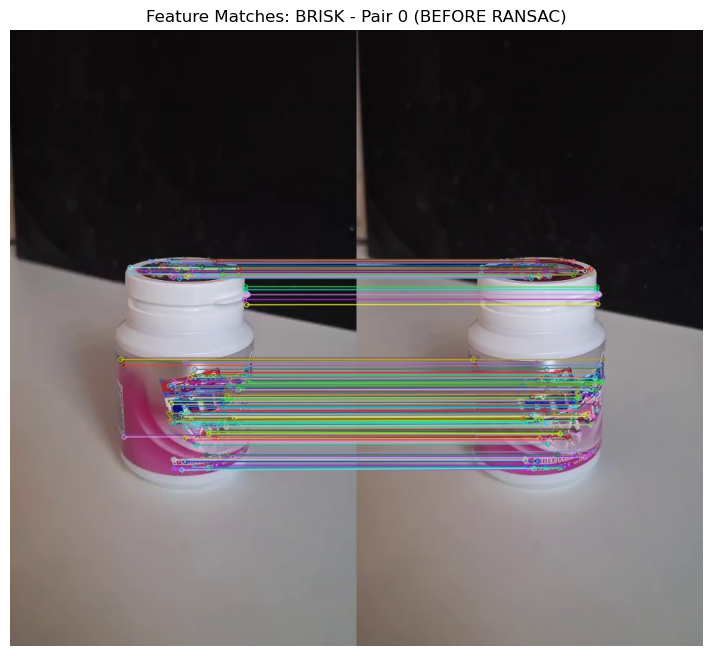

-> Saving feature matches AFTER RANSAC for pair 0 to 'output_matches\Gum_Vid\BRISK'...


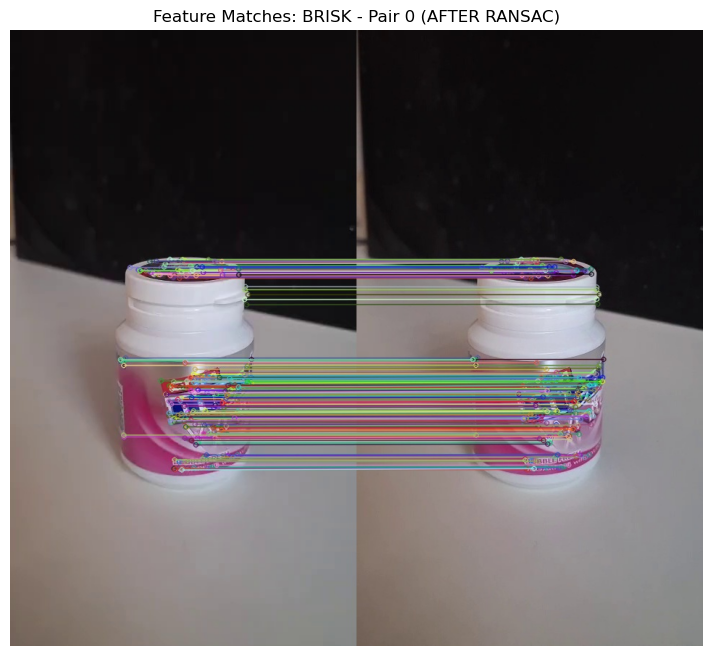

Pair 1: Matches before RANSAC = 276, after RANSAC = 266 -> Retention = 96.4%
-> Saving feature matches BEFORE RANSAC for pair 1 to 'output_matches\Gum_Vid\BRISK'...
-> Saving feature matches AFTER RANSAC for pair 1 to 'output_matches\Gum_Vid\BRISK'...
Pair 2: Matches before RANSAC = 262, after RANSAC = 243 -> Retention = 92.7%
-> Saving feature matches BEFORE RANSAC for pair 2 to 'output_matches\Gum_Vid\BRISK'...
-> Saving feature matches AFTER RANSAC for pair 2 to 'output_matches\Gum_Vid\BRISK'...
Pair 3: Matches before RANSAC = 245, after RANSAC = 231 -> Retention = 94.3%
-> Saving feature matches BEFORE RANSAC for pair 3 to 'output_matches\Gum_Vid\BRISK'...
-> Saving feature matches AFTER RANSAC for pair 3 to 'output_matches\Gum_Vid\BRISK'...
Pair 4: Matches before RANSAC = 205, after RANSAC = 192 -> Retention = 93.7%
-> Saving feature matches BEFORE RANSAC for pair 4 to 'output_matches\Gum_Vid\BRISK'...
-> Saving feature matches AFTER RANSAC for pair 4 to 'output_matches\Gum_Vid\BR

In [146]:
print("\n STEP 4 & 5: MATCHING & MATRIX COMPUTATION \n")

def match_and_filter_features(data1, data2, alg_name): # Removed display_raw_matches
    kp1, des1 = data1['keypoints'], data1['descriptors']
    kp2, des2 = data2['keypoints'], data2['descriptors']

    # Skip if not enough descriptors
    if des1 is None or des2 is None or len(des1) < 2 or len(des2) < 2:
        return [], [], None, None

    # Select matching strategy based on algorithm
    if alg_name in ["SIFT", "BRISK"]:
        matcher = cv2.BFMatcher(cv2.NORM_L2)
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_matches = [m for m, n in raw_matches if m.distance < LOWES_RATIO * n.distance]
    else:
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        good_matches = sorted(matcher.match(des1, des2), key=lambda x: x.distance)

    # Note: RANSAC is applied universally after initial good_matches are found.
    # The 'save_raw_matches' and 'display_raw_matches' flags will be handled in the main loop.

    # Skip if not enough good matches
    if len(good_matches) < MIN_INLIER_COUNT:
        return good_matches, [], None, None

    # Extract point coordinates from matches
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    # Estimate fundamental matrix using RANSAC
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC, 2.0)

    # Filter inliers
    inliers = [m for i, m in enumerate(good_matches) if mask is not None and mask.ravel()[i]]

    return good_matches, inliers, F, mask


def draw_matches(data1, data2, matches, mask, sequence_name, alg_name, stage):
    # Create appropriate subdirectory: before_ransac or after_ransac
    output_subdir = os.path.join(OUTPUT_MATCHES_DIR, sequence_name, alg_name, stage)
    os.makedirs(output_subdir, exist_ok=True)

    match_mask = mask.ravel().tolist() if mask is not None else None
    img_matches = cv2.drawMatches(
        data1['image'], data1['keypoints'],
        data2['image'], data2['keypoints'],
        matches, None,
        matchesMask=match_mask,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    filename = f"{os.path.splitext(data1['filename'])[0]}_" \
            f"{os.path.splitext(data2['filename'])[0]}.jpg"
    save_path = os.path.join(output_subdir, filename)
    cv2.imwrite(save_path, img_matches)
    return save_path



# Filter results by the selected matching algorithm
# Assumes 'results_df' and 'MATCHING_ALGORITHM' are defined in a prior cell
sequence_df = results_df[results_df['algorithm'] == MATCHING_ALGORITHM].reset_index(drop=True)

# Process image pairs and compute fundamental matrices
all_processed_pairs = []

# Flag to ensure visualizations are handled only for the first pair
visualized_first_pair_once = False
# Assumes 'sequence_name' is defined globally from an earlier cell

for i in range(len(sequence_df) - 1):
    data1 = sequence_df.iloc[i]
    data2 = sequence_df.iloc[i + 1]

    # Check if this is the first pair for displaying visualizations
    is_first_pair_for_display = False
    if not visualized_first_pair_once:
        is_first_pair_for_display = True
        visualized_first_pair_once = True # Ensure this only runs once

    # Call match_and_filter_features. It no longer handles display directly.
    raw_matches_pre_ransac_filter, inliers, F, mask = match_and_filter_features(data1, data2, MATCHING_ALGORITHM)

    #calculate ransac retention rate
    num_matches = len(raw_matches_pre_ransac_filter)
    num_inliers = len(inliers)
    if num_matches > 0:
        retention_rate = (num_inliers / num_matches) * 100
        print(f"Pair {i}: Matches before RANSAC = {num_matches}, after RANSAC = {num_inliers} -> Retention = {retention_rate:.1f}%")
    else:
        print(f"Pair {i}: No valid matches found before RANSAC.")

    if len(inliers) >= MIN_INLIER_COUNT:
        # Save and display "BEFORE RANSAC" matches for the first pair
        if is_first_pair_for_display:
            print(f"-> Saving and Displaying feature matches BEFORE RANSAC for first pair to '{os.path.join(OUTPUT_MATCHES_DIR, sequence_name, MATCHING_ALGORITHM)}'...")
            # Use raw_matches_pre_ransac_filter (matches after Lowe's ratio test, before RANSAC filtering)
            raw_matches_path = draw_matches(data1, data2, raw_matches_pre_ransac_filter, None, sequence_name, MATCHING_ALGORITHM, stage="before_ransac")

            # Display the saved image
            plt.figure(figsize=(15, 8))
            plt.imshow(cv2.cvtColor(cv2.imread(raw_matches_path), cv2.COLOR_BGR2RGB))
            plt.title(f"Feature Matches: {MATCHING_ALGORITHM} - Pair {i} (BEFORE RANSAC)")
            plt.axis('off')
            plt.show()
            plt.close()
        else:
            # Just save "BEFORE RANSAC" matches for subsequent pairs (no display)
            print(f"-> Saving feature matches BEFORE RANSAC for pair {i} to '{os.path.join(OUTPUT_MATCHES_DIR, sequence_name, MATCHING_ALGORITHM)}'...")
            # This ensures all intermediate steps are saved for documentation
            draw_matches(data1, data2, raw_matches_pre_ransac_filter, None, sequence_name, MATCHING_ALGORITHM, stage="before_ransac")


        # Save and display "AFTER RANSAC" matches
        print(f"-> Saving feature matches AFTER RANSAC for pair {i} to '{os.path.join(OUTPUT_MATCHES_DIR, sequence_name, MATCHING_ALGORITHM)}'...")
        after_ransac_path = draw_matches(data1, data2, inliers, None, sequence_name, MATCHING_ALGORITHM, stage="after_ransac")

        if is_first_pair_for_display:
            # Display the saved image
            plt.figure(figsize=(15, 8))
            plt.imshow(cv2.cvtColor(cv2.imread(after_ransac_path), cv2.COLOR_BGR2RGB))
            plt.title(f"Feature Matches: {MATCHING_ALGORITHM} - Pair {i} (AFTER RANSAC)")
            plt.axis('off')
            plt.show()
            plt.close()

        all_processed_pairs.append({
            'data1': data1,
            'data2': data2,
            'inliers': inliers,
            'F': F
        })

print(f"Found {len(all_processed_pairs)} valid pairs for reconstruction.\\n")
print(f"Feature match visualizations (saved for all pairs, displayed for first pair) in '{OUTPUT_MATCHES_DIR}'.")

# 6. Camera Positions Estimation

**Methodology:**
The Essential Matrix $E$ can be mathematically decomposed to yield the rotation and translation matrices. However, this decomposition is not unique.

* [cite_start]**The Chirality Problem:** As required to be explained in the report, decomposing $E$ results in four possible solutions for the camera pose ($R, t$). While all four are mathematically valid, only one is physically possible. The correct pose is the one that results in the reconstructed 3D points being in front of both camera centers. This constraint is known as the "chirality check."

* [cite_start]**Implementation:** We use the OpenCV function `cv2.recoverPose(E, pts1, pts2, K)` to handle this entire process.  This function is highly convenient as it:
    1.  Decomposes the Essential Matrix $E$ to find the four possible pose solutions.
    2.  Performs triangulation for each of the four solutions.
    3.  Applies the chirality check to determine which solution places the most 3D points in front of both cameras.
    4.  Returns the correct rotation `R`, translation `t`, and a mask indicating the inlier points that passed the check.

***

In [147]:
print("\n STEP 6: CAMERA POSE ESTIMATION \n")

# Assume focal length equals image width, and principal point is image center
h, w = all_images_data[0]['image_color'].shape[:2]
focal_length = w
K = np.array([
    [focal_length, 0, w / 2],
    [0, focal_length, h / 2],
    [0, 0, 1]
], dtype=np.float32)

print("Using assumed Camera Matrix (K):\n", K)

# Check if we have valid pairs to estimate pose
if not all_processed_pairs:
    print("No valid pairs found to estimate pose.")
else:
    for i, pair_data in enumerate(all_processed_pairs):
        F = pair_data['F']
        inliers = pair_data['inliers']
        kp1 = pair_data['data1']['keypoints']
        kp2 = pair_data['data2']['keypoints']

        # Extract matched inlier points
        pts1 = np.float32([kp1[m.queryIdx].pt for m in inliers])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in inliers])

        # Compute essential matrix from fundamental matrix and camera intrinsics
        E = K.T @ F @ K

        # Recover relative camera pose (rotation R and translation t)
        retval, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

        if retval > 0:
            all_processed_pairs[i]['R'] = R
            all_processed_pairs[i]['t'] = t
            all_processed_pairs[i]['pose_inliers'] = mask_pose
        else:
            all_processed_pairs[i]['R'] = None
            all_processed_pairs[i]['t'] = None

print("\nPose estimation complete.\n")


 STEP 6: CAMERA POSE ESTIMATION 

Using assumed Camera Matrix (K):
 [[478.   0. 239.]
 [  0. 478. 425.]
 [  0.   0.   1.]]

Pose estimation complete.



# 7. 3D Point Triangulation and Scene Visualisation

**Methodology:**
1.  **Triangulation:** Triangulation is the process of determining a point's position in 3D space given its projections onto two or more images with known camera poses. Geometrically, for a given 2D feature match, we can cast a ray from the first camera's center through its 2D point and another ray from the second camera's center through its corresponding 2D point. The 3D coordinate of the feature is the intersection point of these two rays. In our implementation, we use `cv2.triangulatePoints(P1, P2, pts1, pts2)`, where `P1` and `P2` are the projection matrices of the two cameras. [cite_start]This function returns the 3D points in homogeneous coordinates. 

2.  **Scene Chaining:** The pipeline processes image pairs sequentially. The pose of the first camera is set to the origin `[I|0]`. The relative pose `(R, t)` recovered from the first pair `(frame_0, frame_1)` is used to determine the global pose of the second camera. This second camera's pose is then used as the starting point for calculating the pose of the third camera from the pair `(frame_1, frame_2)`, and so on. This "chains" the camera poses together to form a trajectory.

3.  **Point Cloud Filtering:** The initial triangulated point cloud often contains noise and outliers due to minor matching errors. To clean the scene, our `filter_point_cloud` function implements statistical outlier removal. For each point, it calculates the mean distance to its k-nearest neighbors. If a point's mean distance is far from the average mean distance of all points (specifically, greater than a threshold defined by `mean + std_ratio * std_dev`), it is classified as an outlier and removed.

4.  **Visualisation:** To display the final result, we use the Plotly library, which allows for the creation of **interactive 3D plots**, fulfilling the project requirement.  Our visualization includes:
    * The filtered 3D point cloud, representing the reconstructed scene structure.
    * The camera's trajectory, plotted as a red line connecting the positions of each camera pose. This helps visualize the motion used to capture the scene.
    * A green 'x' marker to indicate the starting position of the camera.

***

In [148]:
print("\n STEP 7: TRIANGULATION, FILTERING & VISUALISATION\n")

def filter_point_cloud(points_3d, k_neighbors=20, std_ratio=1.0):
    if points_3d.shape[0] < k_neighbors:
        print("Warning: Not enough points for filtering. Returning original cloud.")
        return points_3d

    # Use FLANN for fast nearest neighbor search
    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    points_flat = points_3d.astype(np.float32)

    # Find the k+1 nearest neighbors (the first is the point itself)
    matches = flann.knnMatch(points_flat, points_flat, k=k_neighbors + 1)

    mean_distances = []
    for i in range(len(matches)):
        distances = [m.distance for m in matches[i][1:]]
        if distances:
            mean_distances.append(np.mean(distances))
        else:
            mean_distances.append(0) # Handle case with no neighbors

    mean_distances = np.array(mean_distances)

    global_mean_dist = np.mean(mean_distances)
    global_std_dist = np.std(mean_distances)

    distance_threshold = global_mean_dist + std_ratio * global_std_dist

    inlier_mask = mean_distances < distance_threshold

    print(f"Filtering: Kept {np.sum(inlier_mask)} of {len(points_3d)} points.")

    return points_3d[inlier_mask]

# Initialize scene elements
camera_poses = []
points_3d = np.empty((0, 3))

# The first camera is at the origin [R|t] = [I|0]
R_global = np.identity(3)
t_global = np.zeros((3, 1))
camera_poses.append(np.hstack((R_global, t_global)))

# Process each valid pair to triangulate points and chain poses
for pair in all_processed_pairs:
    if pair.get('R') is None or pair.get('t') is None:
        continue # Skip pairs where pose estimation failed

    # The pose of the first camera in the pair is the last one we successfully calculated
    R_cam1, t_cam1 = camera_poses[-1][:, :3], camera_poses[-1][:, 3].reshape(3, 1)

    R_relative, t_relative = pair['R'], pair['t']

    # Update global pose for the second camera in the pair
    R_cam2 = R_cam1 @ R_relative
    t_cam2 = t_cam1 + R_cam1 @ t_relative

    pose_cam2 = np.hstack((R_cam2, t_cam2))
    camera_poses.append(pose_cam2)

    # Get the 2D points for triangulation
    kp1, kp2 = pair['data1']['keypoints'], pair['data2']['keypoints']
    inliers = pair['inliers']

    # Filter points further by the chirality check mask from `recoverPose`
    pose_mask = pair.get('pose_inliers')
    if pose_mask is not None:
        inliers = [m for i, m in enumerate(inliers) if pose_mask.ravel()[i]]

    pts1 = np.float32([kp1[m.queryIdx].pt for m in inliers]).T
    pts2 = np.float32([kp2[m.trainIdx].pt for m in inliers]).T

    if pts1.shape[1] == 0 or pts2.shape[1] == 0:
        continue # No points left to triangulate for this pair

    # Create projection matrices for triangulation
    P1 = K @ camera_poses[-2] # The second to last pose
    P2 = K @ camera_poses[-1] # The last pose

    # Triangulate 3D points
    points_4d_hom = cv2.triangulatePoints(P1, P2, pts1, pts2)

    # Convert from homogeneous to 3D coordinates
    points_3d_new = (points_4d_hom[:3, :] / points_4d_hom[3, :]).T
    points_3d = np.vstack((points_3d, points_3d_new))


print(f"Triangulated a total of {points_3d.shape[0]} points.")
print(f"Total camera poses estimated: {len(camera_poses)}")

# Filter the final point cloud to remove outliers
if points_3d.shape[0] > 0:
    points_3d_filtered = filter_point_cloud(points_3d, k_neighbors=30, std_ratio=0.5)
else:
    points_3d_filtered = points_3d # Keep it as an empty array


# Visualize the 3D Scene with Plotly for interactivity
if points_3d_filtered.shape[0] > 0:
    print("\nVisualizing the filtered 3D scene (interactive)...")
    if not os.path.exists(OUTPUT_SCENE_DIR): os.makedirs(OUTPUT_SCENE_DIR)

    # The camera's 3D position is derived from its pose matrix [R|t] as -R.T @ t
    cam_positions = np.array([-pose[:, :3].T @ pose[:, 3] for pose in camera_poses])

    # NORMALIZATION FOR BETTER VISUALIZATION
    mean_point = points_3d_filtered.mean(axis=0)
    points_centered = points_3d_filtered - mean_point
    cams_centered = cam_positions - mean_point
    max_abs_coord = np.max(np.abs(points_centered))
    if max_abs_coord == 0: max_abs_coord = 1 # Avoid division by zero
    points_normalized = points_centered / max_abs_coord
    cams_normalized = cams_centered / max_abs_coord

    # Create the figure
    fig = go.Figure()

    # Add the 3D point cloud
    fig.add_trace(go.Scatter3d(
        x=points_normalized[:, 0],
        y=points_normalized[:, 1],
        z=points_normalized[:, 2],
        mode='markers',
        marker=dict(size=1, color='blue'),
        name='Point Cloud'
    ))

    # Add the camera trajectory
    fig.add_trace(go.Scatter3d(
        x=cams_normalized[:, 0],
        y=cams_normalized[:, 1],
        z=cams_normalized[:, 2],
        mode='lines+markers',
        line=dict(color='red', width=5),
        marker=dict(size=4, color='red'),
        name='Camera Trajectory'
    ))

    # Add the start point
    fig.add_trace(go.Scatter3d(
        x=[cams_normalized[0, 0]],
        y=[cams_normalized[0, 1]],
        z=[cams_normalized[0, 2]],
        mode='markers',
        marker=dict(size=8, color='green', symbol='x'),
        name='Start'
    ))

    # Update the layout
    fig.update_layout(
        title_text='Filtered and Normalized 3D Reconstructed Scene (Interactive)',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    # Save to an interactive HTML file
    interactive_plot_path = os.path.join(OUTPUT_SCENE_DIR, f"{sequence_name}_3d_reconstruction_interactive.html")
    fig.write_html(interactive_plot_path)

    # Show the figure
    fig.show()
    print(f"\nInteractive plot saved to '{interactive_plot_path}'")

else:
    print("\nNo 3D points were reconstructed or all points were filtered out. Cannot visualize scene.")

print("\nFull pipeline complete.")


 STEP 7: TRIANGULATION, FILTERING & VISUALISATION

Triangulated a total of 2731 points.
Total camera poses estimated: 34
Filtering: Kept 2687 of 2731 points.

Visualizing the filtered 3D scene (interactive)...



Interactive plot saved to 'output_scene\Gum_Vid_3d_reconstruction_interactive.html'

Full pipeline complete.
